In [3]:
# Import necessary libraries and set seed
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import keras_tuner

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
keras.utils.set_random_seed(23)

# Load MNIST dataset
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess data
input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0
num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Train-validation split
x_train = x_train_val[:-10000]
x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]
y_val = y_train_val[-10000:]


2024-10-16 13:02:28.588362: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 13:02:28.600836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:02:28.603371: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 13:02:28.610521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 13:02:28.621612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# Define the search space for tuning the number of layers and units
def build_model(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(784,)))

    for L in range(hp.Int("num_layers", 1, 3)):
        M.add(keras.layers.Dense(
            units=hp.Int(f"units_{L}", min_value=700, max_value=900, step=100),
            activation='relu'))

    M.add(keras.layers.Dense(10, activation='softmax'))
    M.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return M

# Define the tuner using Bayesian Optimization
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="/tmp",
    project_name="MNIST"
)

# Display search space summary
tuner.search_space_summary()


Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 700, 'max_value': 900, 'step': 100, 'sampling': 'linear'}


In [5]:
# Perform the search for the best hyperparameters
tuner.search(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val))

# Display the results summary
tuner.results_summary(num_trials=1)

# Get the best model and evaluate it on the test data
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')


Trial 10 Complete [00h 01m 17s]
val_accuracy: 0.9781000018119812

Best val_accuracy So Far: 0.9796000123023987
Total elapsed time: 00h 24m 19s
Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
num_layers: 1
units_0: 900
units_1: 800
units_2: 900
Score: 0.9796000123023987


/home/yassin/anaconda3/envs/per/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.1195
Precisión: 98.0%


Loss: 0.1308
Precisión: 97.8%


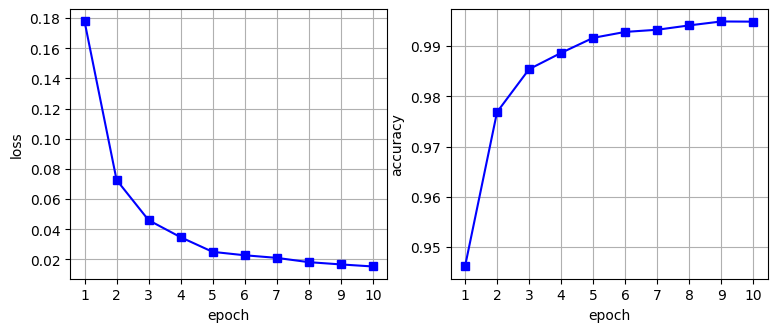

In [6]:
# Retrain the model using the best hyperparameters on the full train-validation set
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(x_train_val, y_train_val, batch_size=16, epochs=10, verbose=0)

# Plot training loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)

ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', marker='s')

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', marker='s')

# Evaluate on test set
score = M.evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')


In [7]:
# Initialize and preprocess Fashion-MNIST dataset
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

input_dim = 784
x_train_val = x_train_val.reshape(-1, input_dim).astype("float32") / 255.0
x_test = x_test.reshape(-1, input_dim).astype("float32") / 255.0

num_classes = 10
y_train_val = keras.utils.to_categorical(y_train_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Train-validation split for Fashion-MNIST
x_train = x_train_val[:-10000]
x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]
y_val = y_train_val[-10000:]


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
